In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = "~/Documents/projects_Spring2018/howe299r/Experiments/03April2018/WIP/"
pos = range(1,16)
IMUDats = [ '%02dIMU.txt'% x for x in pos ]
IMUCols = ['timeSysCal', 'XYZ','X', 'Y', 'Z']
listpos = [1,7, 10,13]
listpos = [0,3,6,9,12]
listpos = [6,8]
BigTheta = []
BigTorque = []
for i in listpos:
    fname =  '%02dIMU.txt'%(i+1)
    imuDat = pd.read_csv(path+fname, header=None,sep=';', 
                        names = IMUCols, skip_blank_lines=True, usecols=[0,1,2,3,4]) #TODO: this is somehow skipping a col, so the last is NaN. usecols to get around this
    imuDat = imuDat.drop(['timeSysCal', 'XYZ'], 1)
    bkgd = imuDat.iloc[0::2]  
    signal = imuDat.iloc[1::2]
    #print(len(bkgd))
    #print(len(sig))
    zer = bkgd.as_matrix()
    sig = signal.as_matrix()
    thetas = sig-zer
    thetaX, thetaY, thetaZ = thetas[:,0], thetas[:,1], thetas[:,2]
    print(thetaZ) ###
    xs = [4.6, 4.1, 3.5, 3.1, 2.6]#pos 1 x = 4.6 cm
    #ys = [0.4, 0.1, -0.2]
    ys = [0.4, 0, -0.2]
    n = thetas.shape[0]
    forces = range(1, n+1) 
    forcesZ = [20*f for f in forces]
    
    posX = np.array([(x,x,x) for x in xs]).flatten()
    posY = np.array(ys *5)
    posZ = np.array([0]*15)
    pos = np.array([posX[i], posY[i], posZ[i]])
    forcesXYZ = np.column_stack((np.zeros((n,2)),forcesZ))
    torques = np.cross(forcesXYZ, pos)
    torquesX, torquesY, torquesZ = torques[:,0] , torques[:,1], torques[:,2]
    #BigTorque.column_stack(np.array(torquesY))
    BigTorque.append(np.array(torquesY))
    BigTheta.append(np.array(thetaY))
    #BigTheta.column_stack(np.array(thetaY))
print('exit loop')
np.concatenate(BigTheta).ravel()
np.concatenate(BigTorque).ravel()
BigTheta = np.hstack(BigTheta)
BigTorque= np.hstack(BigTorque)
#print(len(BigTheta[2]))
#print('exit loop')
#print(BigTorque)
#print(len(BigTorque))
#print(BigTheta)
    

[ 0.     -0.0625 -0.125  -0.0625 -0.125  -0.0625 -0.125  -0.1875 -0.25
 -0.1875 -0.1875 -0.25   -0.3125 -0.5    -0.3125 -0.1875 -0.375  -0.4375
 -0.4375 -0.5625 -0.6875 -0.6875 -0.8125 -0.6875 -1.     -0.625  -0.75
 -1.1875 -0.875  -0.875 ]
[0.125  0.125  0.1875 0.3125 0.3125 0.1875 0.5    0.4375 0.375  0.5625
 0.625  0.5625 0.75   0.875  0.8125 0.875  0.9375 0.9375 1.125  1.1875
 1.125  1.4375 1.25   1.375  1.5    1.5    1.625  1.5625 2.0625 1.6875
 2.0625 2.     1.9375]
exit loop


In [129]:
%matplotlib tk
import plotly.plotly as py
import plotly.offline as po
import plotly.graph_objs as go
from sklearn import linear_model
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error, r2_score

po.init_notebook_mode(connected=True)

torquesY = BigTorque
thetaY = BigTheta
#print(torquesY)
#print(thetaY)
trace0 = go.Scatter( x = torquesY, y = thetaY, mode = 'markers',
    name = 'degrees (by IMU)' )

#forcesXYZ = forcesXYZ.reshape(-1, 1)
myX = torquesY.reshape(-1,1)
myy = thetaY 
#print(len(thetas))
#regr= Ridge(fit_intercept=True, alpha=1.0, random_state=0, normalize=True)
regr = linear_model.LinearRegression()
regr.fit(myX, myy)
coef_ridge = regr.coef_
gridx = np.linspace(myX.min(), myX.max(), 20)
coef_ = regr.coef_ * gridx + regr.intercept_
print('test')
print(regr.coef_)
print(regr.intercept_)
yPred= regr.predict(myX) 
#plt.plot(gridx, coef_, 'g-', label="ridge regression")

trace2 = go.Scatter( x= gridx, y = coef_,
    name = 'linear fit (w/ridge penalty)' )

data = [trace0, trace2]
    
layout = go.Layout(
    title='torque vs Degrees of Deflection',
    yaxis=dict(title='degrees'),
    xaxis=dict(title='torque (in grams)'),
    legend=dict(x=.1, y=-.5) )

fig = go.Figure(data=data, layout=layout)
# Plot and embed in ipython notebook!

print('Coefficients: \n', regr.coef_)
print("Mean squared error: %.2f" % mean_squared_error(thetaY, yPred))
#print('Variance score (ideal 1): %.2f' % r2_score(thetaY))
po.iplot(fig)

test
[-0.00646033]
0.24249366497412517
Coefficients: 
 [-0.00646033]
Mean squared error: 0.49


In [127]:
%matplotlib tk
resid = thetaY - yPred 
traceResid = go.Scatter( x = thetaY, y = resid, mode = 'markers',
    name = 'resid vs trueY' )
traceResid2 = go.Scatter( x = yPred, y = resid, mode = 'markers', 
                         marker=dict(size='5', color='red'),
                        name = 'resid vs estY')
data = [traceResid, traceResid2]
layout = go.Layout(
    title='Residuals',
    yaxis=dict(title='residuals'),
    xaxis=dict(title='yIMU (degrees)'),
    legend=dict(x=.1, y=-.5) )

fig = go.Figure(data=data, layout=layout)
po.iplot(fig)
print(thetaY)
print(resid)

[ -1.4375  -1.3125  -1.6875  -3.1875  -3.0625  -2.6875  -5.      -4.6875
  -5.125   -6.5625  -6.9375  -6.75    -8.5625  -8.875   -8.     -10.3125
 -10.8125 -10.375  -12.5    -11.375  -11.4375  -1.3125  -1.0625  -1.375
  -2.25    -2.75    -2.8125  -4.1875  -4.375   -4.4375  -5.5     -5.6875
  -5.6875  -6.75    -7.8125  -7.5625  -8.4375  -8.5     -8.875  -10.3125
 -10.5625 -10.4375 -11.875  -12.4375 -12.3125  -1.1875  -1.0625  -1.125
  -2.5     -2.25    -1.8125  -3.0625  -3.625   -3.4375  -5.25    -4.625
  -4.75    -5.5625  -6.3125  -6.8125  -6.125   -7.6875  -8.3125  -8.5
  -9.1875  -9.375  -10.8125 -11.125  -11.1875 -12.75   -11.6875 -12.8125
 -15.3125 -14.     -13.875   -0.8125  -0.8125  -0.9375  -2.      -1.875
  -1.8125  -2.9375  -2.75    -3.      -3.75    -3.875   -3.8125  -5.125
  -5.      -5.      -5.875   -6.1875  -6.5     -7.3125  -7.5     -8.0625
  -8.875   -8.875   -8.     -10.0625 -10.4375 -10.     -11.     -11.625
 -11.4375 -13.4375 -12.875  -13.1875 -13.4375 -13.9375 -14.9

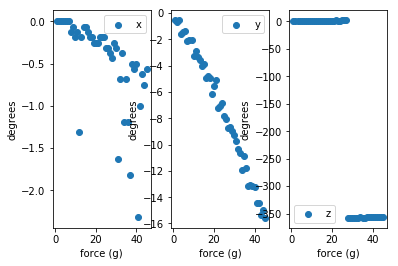

In [108]:
%matplotlib inline
plt.subplot(131)
plt.scatter(forces, thetaX, label='x')
plt.ylabel('degrees')
plt.xlabel('force (g)')
plt.legend()
plt.subplot(132)
plt.scatter(forces, thetaY, label='y')
plt.ylabel('degrees')
plt.xlabel('force (g)')
plt.legend()
plt.subplot(133)
plt.scatter(forces, thetaZ, label='z')
plt.ylabel('degrees')
plt.xlabel('force (g)')
plt.legend()
plt.show()

In [109]:
import numpy as np
import plotly.plotly as py
import plotly.offline as po
import plotly.graph_objs as go
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

po.init_notebook_mode(connected=True)
trace0 = go.Scatter( x = forces, y = yIMU, mode = 'markers',
    name = 'degrees (by IMU)' )

forces = forces.reshape(-1, 1)
myX = forces
myy = yIMU 
#regr= Ridge(fit_intercept=True, alpha=1.0, random_state=0, normalize=True)
regr = linear_model.LinearRegression()
regr.fit(myX, myy)
coef_ridge = regr.coef_
gridx = np.linspace(myX.min(), myX.max(), 20)
coef_ = regr.coef_ * gridx + regr.intercept_
yPred= regr.predict(myX) 
#plt.plot(gridx, coef_, 'g-', label="ridge regression")

trace2 = go.Scatter( x= gridx, y = coef_,
    name = 'linear fit (w/ridge penalty)' )
           

NameError: name 'yIMU' is not defined

In [ ]:
#kest = torques / thetas
# thetas 21.3

# forces 21.3 
# pos 1.3 
#torques 21.3

